The majority of the code devolepped in this notebook is refactored in a stand-alone s3-quotes-trades-parsing module.

In [1]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import dask
import csv
import seaborn as sns
from pathlib import Path


Define an env varibale for the AWS profile and create an s3 bucket resource

In [2]:
%env AWS_PROFILE = dynamodbSobCap

s3 = boto3.resource("s3")
bucket = s3.Bucket('sobesice-capital-data')

env: AWS_PROFILE=dynamodbSobCap


In [3]:
# %%timeit
obj = bucket.Object("crypto-data/bitmex/quotes/XBTUSD/2020-12-20.csv").get()
data = pd.read_csv(obj['Body'])

Lets see a sample of the contents in the bucket

In [4]:
[ob.key for i, ob in enumerate(bucket.objects.filter(Prefix='crypto-data/bitmex/')) if i < 10]

['crypto-data/bitmex/quotes/BCHUSD/2020-11-17.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-18.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-19.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-20.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-21.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-22.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-23.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-24.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-25.csv',
 'crypto-data/bitmex/quotes/BCHUSD/2020-11-26.csv']

Define read method bucket to pandas + other utilities.

In [16]:
def read_boto_obj_to_df(ticker, date, style):
    """
    Read raw csv to pandas DF
      - type quotes or trades
    """
    root_path = 'crypto-data/bitmex/'
    if style == 'quotes':
        nms = ['timestamp', 'bid', 'ask', 'bidsize', 'asksize']
        # typesdict = {'timestamp': 'str', 'bid': np.float64, 'ask': np.float64, 'bidsize': np.int32, 'asksize': np.int32}
    elif style == 'trans':
        nms = ['timestamp', 'ordertype', 'volume', 'price', 'ticktype']
        # typesdict = {'timestamp': 'str', 'ordertype': ''}
    else:
        raise ValueError("Unknown data processing type. Supported types are 'quotes' and ' trans'.")

    path = os.path.join(root_path, style + '/', ticker + '/', date + '.csv')
    print(path)
    obj = bucket.Object(path).get()
    
    df = pd.read_csv(obj['Body'], header=None, names=nms)
    df.index = pd.to_datetime(df.timestamp)
    df = df.drop(labels='timestamp', axis=1)
    if style == 'quotes':
        df.bid = pd.to_numeric(df.bid, errors='coerce')
        df.ask = pd.to_numeric(df.ask, errors='coerce')
        df.bidsize = pd.to_numeric(df.bidsize, errors='coerce')
        df.asksize = pd.to_numeric(df.asksize, errors='coerce')
    else:
        df.volume = pd.to_numeric(df.volume, errors='coerce')
        df.price = pd.to_numeric(df.price, errors='coerce')
    return df

def get_instruments(style='trans'):
    if style == 'quotes':
        dirty_inst_list = [key.key.split('/')[3] for key in bucket.objects.filter(Prefix='crypto-data/bitmex/quotes/')]
    elif style == 'trans':
        dirty_inst_list = [key.key.split('/')[3] for key in bucket.objects.filter(Prefix='crypto-data/bitmex/trans/')]
    else:
        raise ValueError("Supported style are limitted to 'trans' and 'quotes'.")
    unique_list = list(set(dirty_inst_list))
    return unique_list

def get_availability(instrument, style='trans', verbose=True, return_type = 'series'):
    if style not in ['trans', 'quotes']:
        raise ValueError("Supported style are limitted to 'trans' and 'quotes'.")
    else:
        path = 'crypto-data/bitmex/' + style + '/' + instrument
    try:
        string_dates = [key.key.split('/')[-1].split('.')[0] for key in bucket.objects.filter(Prefix=path)]
        avail = pd.Series(pd.to_datetime(string_dates).sort_values())
        start_date = avail.iloc[0].date()
        end_date = avail.iloc[-1].date()
        missing = pd.Series(pd.date_range(start = start_date, end = end_date).difference(avail))
    except:
        raise ValueError('Symbol not available.')
    
    if verbose:
        print(f'{instrument}')
        print(f'Total days: {len(avail)}')
        print(f'Missing days: {len(missing)}, i.e., {(len(missing))/(len(missing) + len(avail)) * 100:.2f} % missing.')
        print(f'First date of data: {start_date}')
        print(f'Last date of data: {end_date}')
        
    if return_type == 'series':
        return avail, missing
    elif return_type =='string':
        return string_dates, missing
    else:
        raise ValueError('Unknown return type.')

def plot_availability(symbols, style='trans', plot=True):
    "Plots the availability graph"
    df = []
    for i, sym in enumerate(symbols):
        dates, missing = get_availability(sym, style=style, verbose=False)
        dates.index = dates
        dates[:] = i
        df.append(dates)
        ret_df = pd.concat(df, axis=1, join='outer')
    ret_df.rename(columns={i:s for i, s in enumerate(symbols)}, inplace=True)
    if plot:
        ret_df.plot(marker='x', linestyle='-')
    return ret_df
        
        

In [6]:
all_trans_data = [s for s in get_instruments(style='trans') if s!='navidrak']
all_quotes_data = [s for s in get_instruments(style='quotes') if s!='navidrak']


In [7]:
dates, missing = get_availability('XBTUSD', style='trans', verbose=True, return_type='string')

XBTUSD
Total days: 550
Missing days: 82, i.e., 12.97 % missing.
First date of data: 2019-04-11
Last date of data: 2021-01-01


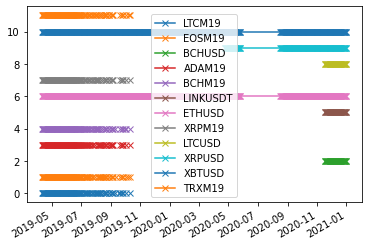

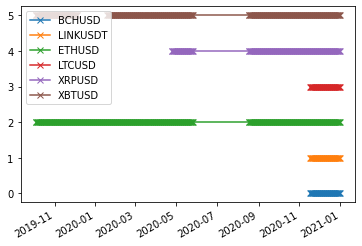

In [8]:
df1 = plot_availability(all_trans_data, style='trans', plot=True)
df2 = plot_availability(all_quotes_data, style='quotes', plot=True)

Visually it looks like we have quote files for all transaction files. Let's check this with a short script.

Furthermore, we observe that something funky is going in the futures contracts. The availability is deteriorating as time progresses. It is expected that the contract won't be traded after its expiration, however, contiguous avaialability which is not the case. Lastly all perpetuities contain uninterupted data feed with longest history available in XRPUSD, XBTUSD and ETHUSD.

In [9]:
futures = [word for word in all_trans_data if word.endswith('19')]
perpetuities = [word for word in all_trans_data if not word.endswith('19')]

In [10]:
perp_avail_t = plot_availability(perpetuities, style='trans', plot=False)
perp_avail_q = plot_availability(perpetuities, style='quotes', plot=False)
futures_avail_t = plot_availability(futures, style='trans', plot=False)

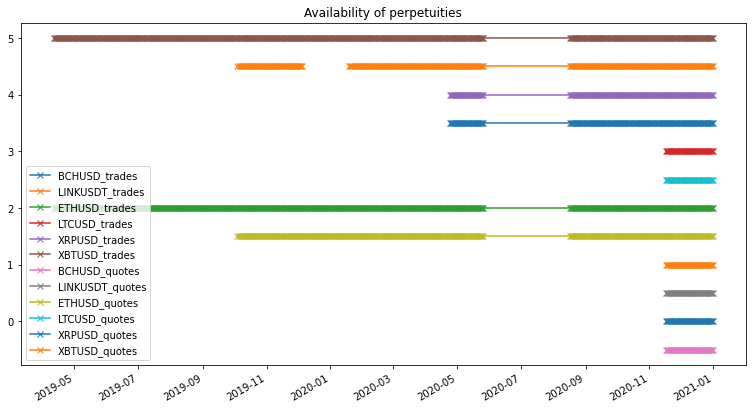

In [11]:
perp_avail_t.join(perp_avail_q-0.5, how='outer', lsuffix='_trades', rsuffix='_quotes').plot(title='Availability of perpetuities', marker='x', figsize=(13,7))

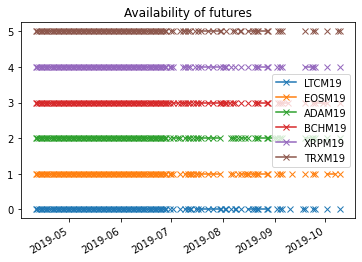

In [12]:
futures_avail_t.plot(title='Availability of futures', marker='x')


## Build database

In [17]:
btc_trade = read_boto_obj_to_df('XBTUSD', '2020-11-20', 'trans')

crypto-data/bitmex/trans/XBTUSD/2020-11-20.csv


In [18]:
df = btc_trade

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378892 entries, 2020-11-20 00:00:00.993000+00:00 to 2020-11-20 23:59:58.714000+00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ordertype  378892 non-null  object 
 1   volume     378892 non-null  int64  
 2   price      378892 non-null  float64
 3   ticktype   378892 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 14.5+ MB


In [20]:
df.to_csv('compressedcsv.csv.gz', compression='gzip')
df.to_csv('mycsv.csv')

In [21]:
df.to_hdf('hdfcsv.h5', key='df', mode='w')

In [22]:
df.to_parquet('parquetcsv.parquet')
df.to_parquet('parquetcsv.parquet.gzip', compression='gzip')

In [23]:
%%timeit
pd.read_csv('compressedcsv.csv.gz')

350 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
pd.read_csv('mycsv.csv')

355 ms ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
pd.read_hdf('hdfcsv.h5')

64.6 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit
pd.read_parquet('parquetcsv.parquet')

61.6 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%timeit
pd.read_parquet('parquetcsv.parquet.gzip')

63.4 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
btc_trade = read_boto_obj_to_df('XBTUSD', '2020-11-20', 'trans')

crypto-data/bitmex/trans/XBTUSD/2020-11-20.csv


Judging from this analysis I will stick to the Apache's parquet format.

Lastly lets check the size of the dataset.

In [29]:
import joblib
import multiprocessing

CPU_COUNT = multiprocessing.cpu_count()

def estimate_symbol_size(instrument, style='trans'):
    if style not in ['trans', 'quotes']:
        raise ValueError("Supported style are limitted to 'trans' and 'quotes'.")
    else:
        path = 'crypto-data/bitmex/' + style + '/' + instrument
    try:
        string_dates = [key.get()['ContentLength']/1e6 for key in bucket.objects.filter(Prefix=path)]
    except:
        raise ValueError('Symbol not available.')
    
    return string_dates

def estimate_data_size(symbols):
    # super inefficient
    # I wish we could do this in parallel but the estimate_symbol_size cannot be pickled
    total_size = 0
    for s in symbols:
        total_size += np.sum(estimate_symbol_size(s, 'trans'))
        total_size += np.sum(estimate_symbol_size(s, 'quotes'))
    return total_size

        

In [31]:
# total_size = estimate_data_size(perpetuities)
print('There is over 80GB of .csv data only in perpetuities.')

There is over 80GB of .csv data only in perpetuities.


### Load parquet
Lets build data manipulation function.

In [32]:
l = read_boto_obj_to_df('LTCUSD','2020-12-26','quotes')

crypto-data/bitmex/quotes/LTCUSD/2020-12-26.csv


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [33]:
PATH_BITMEX_DATA = '/Users/mmark/crypto-sobcap-data/bitmex'

In [34]:
def list_data(instrument, style, format_type='.parquet', verbose=True, return_type='dates'):
    path = os.path.join(PATH_BITMEX_DATA, instrument, style)
    files = [f for f in os.listdir(path) if f.endswith(format_type)]
    file_paths = [os.path.join(path, f) for f in files]
    if verbose:
        file_sizes = np.sum([os.path.getsize(f) for f in file_paths])
        print(f'Total size: {file_sizes/1e6} MB')
    dates = [f.split('.')[0] for f in files]
    dates.sort()
    file_paths.sort()
    if return_type == 'dates':
        return dates
    elif return_type =='paths':
        return file_paths
    else:
        raise ValueError("Unknown return type. Use 'dates' or 'paths'.")

def load_data(symbol, date, style='trans', format_type='.parquet'):
    parq_path = os.path.join(PATH_BITMEX_DATA, symbol, style, date+format_type)
    df = pd.read_parquet(parq_path)
    return df

In [35]:
eth_quote_files = list_data('ETHUSD','quotes')

Total size: 2704.763156 MB


Lets take a look whether the market got faster -- i.e. are quotes changing more rapidly? 

In [36]:
def daily_activity_profile(symbol):
    quotes_per_hour = []
    trades_per_hour = []
    symbol_quote_files = list_data(symbol,'quotes', verbose=False)
    symbol_trade_files = list_data(symbol, 'trans', verbose=False)
    for symbol_quote_file in symbol_quote_files:
        df_temp = load_data(symbol, symbol_quote_file, 'quotes')
        quotes_per_hour.append([df_temp.shape[0]/24])
        
    for symbol_trade_file in symbol_trade_files:
        df_temp = load_data(symbol, symbol_trade_file, 'trans')
        trades_per_hour.append([df_temp.shape[0]/24])
        
    df1 = pd.DataFrame(quotes_per_hour, columns=['quotes'], index=pd.to_datetime(symbol_quote_files))
    df2 = pd.DataFrame(trades_per_hour, columns=['trans'], index=pd.to_datetime(symbol_trade_files))
    return df1.join(df2)
        

In [37]:
dap  = daily_activity_profile('ETHUSD')

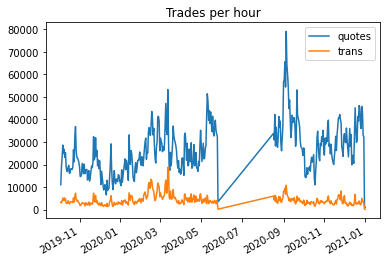

In [38]:
dap.plot(title='Trades per hour')

so it looks like the ETH market did not get any faster

Lets test dask

In [39]:
from dask import dataframe as dd
from dask import delayed

@delayed
def load_data_del(parq_path):
    df = pd.read_parquet(parq_path)
    return df

In [40]:
eth_trans_paths = list_data('ETHUSD', 'trans', verbose=True, return_type='paths')

Total size: 367.259523 MB


In [41]:
list_of_frames = [load_data_del(pq_path) for pq_path in eth_trans_paths]

In [42]:
all_trades = dask.compute(list_of_frames)[0]

In [43]:
all_trades = pd.concat(all_trades)

In [44]:
all_trades = all_trades.sort_index()

In [46]:
p = os.path.join(PATH_BITMEX_DATA, 'ETHUSD', 'trans')

In [47]:
frames = dd.read_parquet(p + '/2020-*-*.parquet', split_row_groupsbool=True)

In [56]:
f = frames.price.compute()

In [58]:
f = f.sort_index()

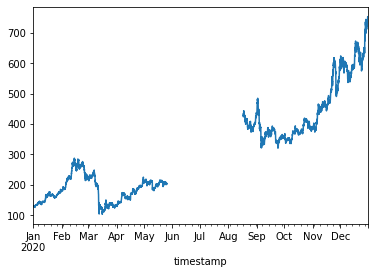

In [61]:
f.resample('1h').mean().plot()

### This is where we end now

In [281]:
btc_quote = read_boto_obj_to_df('XBTUSD', '2020-11-20', 'quotes')

crypto-data/bitmex/quotes/XBTUSD/2020-11-20.csv


In [47]:
start_time = btc_quote.index[0]
end_time = start_time + pd.Timedelta('100s')
btc_quote_slice = btc_quote[(btc_quote.index >= start_time) & (btc_quote.index<=end_time)]

In [13]:
btc_trade[(btc_trade.index >= start_time) & (btc_trade.index<=end_time)]

,timestamp,ordertype,volume,price,ticktype
timestamp,,,,,
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,Sell,640,17823.5,MinusTick
2020-11-20 00:00:00.993000+00:00,2020-11-20T00:00:00.993Z,Sell,1257,17823.5,ZeroMinusTick
2020-11-20 00:00:01.020000+00:00,2020-11-20T00:00:01.020Z,Buy,10,17824.0,PlusTick
2020-11-20 00:00:01.026000+00:00,2020-11-20T00:00:01.026Z,Buy,11,17824.0,ZeroPlusTick


In [14]:
btc_quote.join(btc_trade, how='inner', lsuffix='_left', rsuffix='_right').shape

(379792, 10)

In [41]:
merged_btc_outter = btc_quote.join(btc_trade, how='outer', lsuffix='_left', rsuffix='_right')
merged_btc_inner = btc_quote.join(btc_trade, how='inner', lsuffix='_left', rsuffix='_right')
print(btc_trade.shape)
print(btc_quote.shape)
print(merged.shape)
print(merged_btc_outter[~pd.isna(merged_btc_outter.timestamp_right)].shape)

(378892, 5)
(2263566, 5)
(2486118, 10)
(380051, 10)


In [52]:
str(Path.home())

'/Users/mmark'

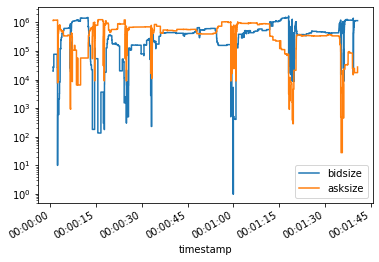

In [49]:
btc_quote_slice[['bidsize', 'asksize']].plot(drawstyle="steps-post")
plt.yscale('log')

In [ ]:
os.geth

In [ ]:
def bin_index(df, bin_size):
    remainder = btc.price%bin_size
    df[remainder!=0] + 

In [74]:
cut, bins = pd.cut(slice1.price, 15, retbins=True)

In [75]:
slice1.groupby(pd.cut(slice1.price, 15)).sum().volume

price
(17805.864, 17815.1]    1006937
(17815.1, 17824.2]       394322
(17824.2, 17833.3]       607847
(17833.3, 17842.4]       600754
(17842.4, 17851.5]      1260373
(17851.5, 17860.6]      1513516
(17860.6, 17869.7]       404594
(17869.7, 17878.8]      1101847
(17878.8, 17887.9]      6160948
(17887.9, 17897.0]      6734039
(17897.0, 17906.1]      4689832
(17906.1, 17915.2]      5465378
(17915.2, 17924.3]      6196717
(17924.3, 17933.4]      1510309
(17933.4, 17942.5]      4002174
Name: volume, dtype: int64

In [85]:
profile = slice1.groupby(pd.cut(slice1.price, 20)).sum().volume
profile

price
(17805.864, 17812.825]     858610
(17812.825, 17819.65]      256331
(17819.65, 17826.475]      428213
(17826.475, 17833.3]       465952
(17833.3, 17840.125]       345523
(17840.125, 17846.95]      411602
(17846.95, 17853.775]     1566202
(17853.775, 17860.6]      1051316
(17860.6, 17867.425]       173736
(17867.425, 17874.25]      596061
(17874.25, 17881.075]     2370588
(17881.075, 17887.9]      4527004
(17887.9, 17894.725]      5314260
(17894.725, 17901.55]     5131434
(17901.55, 17908.375]     2608466
(17908.375, 17915.2]      3835089
(17915.2, 17922.025]      6025971
(17922.025, 17928.85]      952781
(17928.85, 17935.675]     2903459
(17935.675, 17942.5]      1826989
Name: volume, dtype: int64

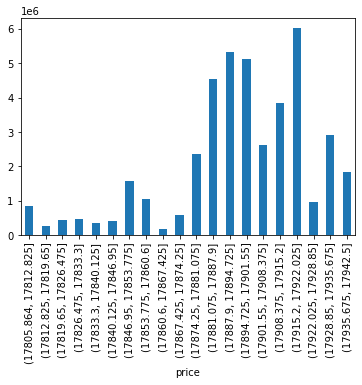

In [86]:
profile.plot.bar()

AttributeError: module 'matplotlib.pyplot' has no attribute 'barplot'

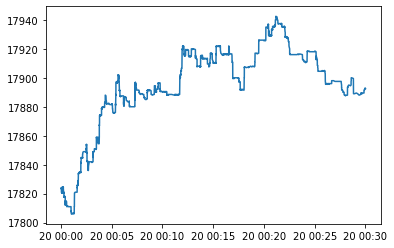

In [88]:
plt.plot(slice1.price)
plt.barplot(profile)

In [ ]:
plt.bar()

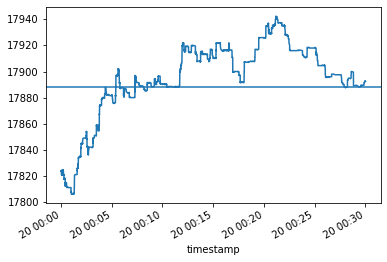

In [77]:
slice1.price.plot()
plt.axhline(bins[9])

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


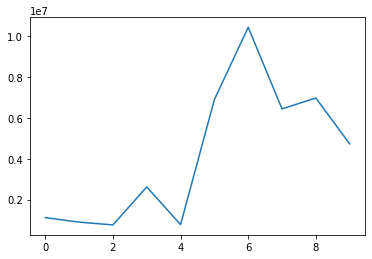

In [51]:
plt.plot(slice1.groupby(pd.cut(slice1.price, 10)).sum().volume)

In [26]:
slice1 = btc[btc.index < btc.index[0] + pd.Timedelta('30min')]

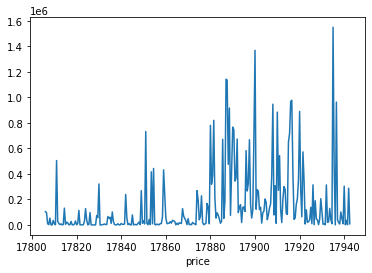

In [24]:
slice1.groupby('price').volume.sum().plot()

In [ ]:
ticker = BCHUSD
'crypto-data/bitmex/quotes/' + ticker +